In [ ]:
!git clone https://github.com/ofekih/LightsOutChallenge.git
!rm -rf .git/ LightsOutChallenge/LightsOutChallenge.ipynb build/ src/
!mv LightsOutChallenge/* LightsOutChallenge/.??* .
!mv bin/* /usr/local/lib/
!rmdir LightsOutChallenge/ bin/
!ldconfig

fatal: destination path 'LightsOutChallenge' already exists and is not an empty directory.
mv: cannot stat 'LightsOutChallenge/*': No such file or directory
mv: cannot move 'LightsOutChallenge/.ipynb_checkpoints' to './.ipynb_checkpoints': Directory not empty
mv: cannot stat 'bin/*': No such file or directory
rmdir: failed to remove 'LightsOutChallenge/': Directory not empty
rmdir: failed to remove 'bin/': No such file or directory
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [ ]:
!make

make: *** No rule to make target 'src/LightsOutBoardWrapper.cpp', needed by 'all'.  Stop.


## Modifying C++ Code
If you want to make changes to the C++ python modules (e.g.: to support different board sizes, then do the following):  
Note: You need python3 (any version should be OK) installed.

### Setup
#### For local machine

1. Get boost python by running the next line (should work on any linux/debian machine)  
   Note: This command takes a very long time, only do this once
   ```bash
   make get_boost_python
   ```

2. Take note of your python3 minor version (over here it's python 3.6)  
   Note: Python 3.6.* all have minor version '6' for these purposes
    ```bash
   python3 --version
   ```

#### For Google Colab


1. Restart the runtime (don't run `make` yet) (Note: not factory reset!)

### Making changes

1. Make changes to the C++ files in `src/`

2. Recompile them with the below command:  
    Note: Substitute '8' with your python3 minor version number.  
    Note: Defaults to '6', so can be omitted if running on Google Colab  
    
    ```bash
    make PYTHON_MINOR_VERSION=8
    ```

   Note: On Google Colab, runtime has to be restarted every time before or after any changes in order to unload the python module. You would probably just restart the runtime, make some changes to the C++, and then run the `make` command above (no need to pull GitHub code again).

3. Make a Git commit and push your changes (cannot be done through Colab)

In [ ]:
import matplotlib.pyplot as plt
def plot(xlist, ylist, xlabel=None, ylabel=None, title=None, error=None, label=None, secondxlist=None, secondylist=None, seconderror=None, secondylabel=None, secondlabel=None, xscale='linear'):
  fig, ax1 = plt.subplots(figsize=(6,6))

  ax1.set_xscale(xscale)

  if secondxlist:
      ax2 = ax1.twinx()
      ax2.errorbar(secondxlist, secondylist, seconderror, color = 'green', ecolor = 'orangered', label = secondlabel)
      ax2.set_ylabel(secondylabel)

  ax1.errorbar(xlist, ylist, error, ecolor = 'red', label = label)
  ax1.set_xlabel(xlabel)
  ax1.set_ylabel(ylabel)
  plt.title(title)
  plt.grid(True)

  if label:
    ax1.legend(loc = 'lower left')

  if secondlabel:
    ax2.legend(loc = 'upper left')

  plt.show()

# **Problem statement**

Lights Out is an electronic game released by Tiger Electronics in 1995. The game consists of a N by N grid of lights (original game is 5 by 5). When the game starts, a random number or a stored pattern of these lights is switched on. Pressing any of the lights will toggle it and the adjacent lights. The goal of the puzzle is to switch all the lights off, preferably in as few button presses as possible. An example of playing the game: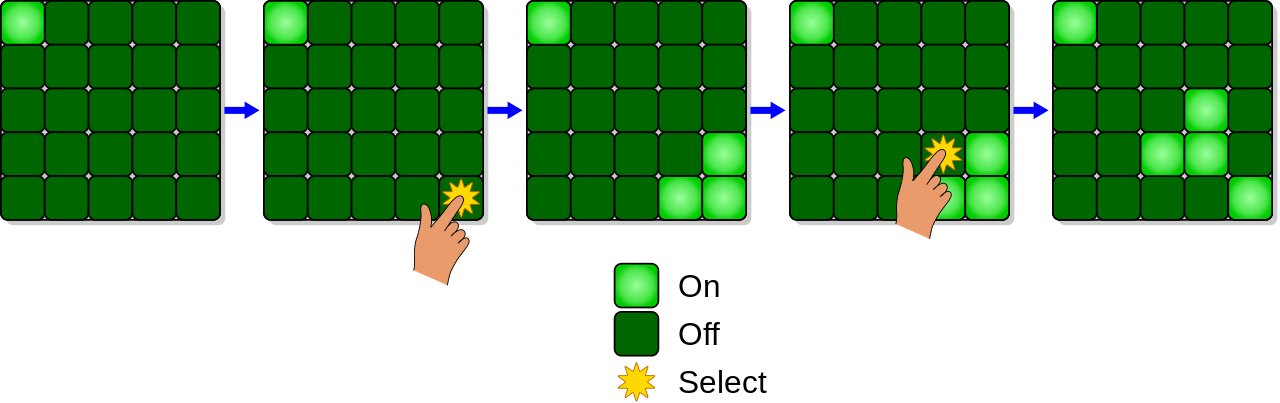

(can add more here!)

# **Previous work**

The problem can be mathematically formulated as solving a set of linear equations, as decsribed in paper [1]. To see why this is the case, let's try using tensors to express the problem. Each board can be expressed as a binary matrix, where 1 represents light's on and 0 represents lights off. For example, consider the 3 boards in the image above, we can express them as:

$$
\begin{pmatrix} 1&0&0&0&0 \\ 0&0&0&0&0 \\ 0&0&0&0&0\\ 0&0&0&0&0 \\ 0&0&0&0&0 \end{pmatrix} \quad
\rightarrow \quad
\begin{pmatrix} 1&0&0&0&0 \\ 0&0&0&0&0 \\ 0&0&0&0&0\\ 0&0&0&0&1 \\ 0&0&0&1&1 \end{pmatrix} \quad
\rightarrow \quad
\begin{pmatrix} 1&0&0&0&0 \\ 0&0&0&0&0 \\ 0&0&0&1&0\\ 0&0&1&1&0 \\ 0&0&0&0&1 \end{pmatrix}
$$

To make linear transformation convenient, we can **reshape** a $(n+1)\times(n+1)$ board matrix into a vector by connecting its rows:

$$
B =
\begin{pmatrix} 
b_{00} & b_{01} & b_{02} & \dots & b_{0n} \\ 
b_{10} & \ddots & & & \\ 
b_{20} & & \ddots & & \vdots \\ 
\vdots & & & \ddots & \\ 
b_{n0} & & \dots & & b_{nn} 
\end{pmatrix} \quad
\rightarrow \quad
\vec{b} = 
\begin{pmatrix} 
b_{00} & b_{01} & b_{02} & \dots & b_{ij} & \dots & b_{nn} 
\end{pmatrix}^T
$$

Similarly, an action (pressing a light) on the board can be expressed as a matrix (reshaped as a vector) as well. For example, pressing the light on row 2, column 3 (indexes start from 0) on a 5 by 5 board is:

$$
A_{23} = 
\begin{pmatrix} 0&0&0&0&0 \\ 0&0&0&1&0 \\ 0&0&1&1&1\\ 0&0&0&1&0 \\ 0&0&0&0&0 \end{pmatrix} \quad
\rightarrow \quad
\vec{a_{23}} = 
\begin{pmatrix} 
\dots & 1&0&0&0&1&1&1&0&0&0&1& \dots
\end{pmatrix}^T
$$

As described in paper [1], there are two important properties of this game:
1. Pushing a button twice is equivalent to not pushing it at all. Hence, for any given configuration, we need consider only solutions in which each button is pushed no more than once.
2. The state of a button depends only on how often (whether even or odd) it and its neighbors have been pushed. Hence, the order in which the buttons are pushed is immaterial

This implies that the solution of the light board will be a **set** of action action vectors:

$$
S = \{\vec{a_{ij}}: i, j \in \{0,1,2,\dots,n\}\}
$$

We can then use the **configuration matrix** (reshaped as a vector) to express the solution:

$$
\vec{x} = 
\begin{pmatrix} 
x_{00} & x_{01} & \dots & x_{ij} & \dots & x_{nn}
\end{pmatrix}^T \qquad
\begin{equation}
  x_{ij} =
  \begin{cases}
    1 & \text{if light$_{ij}$ needs to be pressed} \\
    0 & \text{if light$_{ij}$ needs not to be pressed}
  \end{cases}
\end{equation}
$$

and the problem becomes solving the linear system:

$$
A\vec{x}=\vec{b}
$$

where $A$ is defined as:

$$
A =
\begin{pmatrix} 
| & | & & | & & | \\ 
\vec{a_{00}} & \vec{a_{01}} & \dots & \vec{a_{ij}} & \dots & \vec{a_{nn}} \\ 
| & | & & | & & | \\ 
\end{pmatrix} \quad \tag{1}
$$

One thing to notice is that any addition involved will be modular-two addition, since all matrices and vectors involved are binary.

The problem can be generalized to graph, with applications in quantum circuit simplification [2]. Suppose we consider an open graph **G** whose vertices are labelled
with 0’s and 1’s. Define an operation **flipv**
,
which flips all of the bits on the neighbours of a given vertex **v**. Our goal is to propagate
all of the 1's present in **G** to a set of vertices defined as  **output vertices** using only applications of the operation **flipv**. The positions of **output vertices** do not have restrains.

Now we define the concept of a **focused gFlow** on a graph:

**Definition:**
Given an open graph $G$, a *focused gFlow* $(g, ≺)$ on $G$ consists of a
function $g$ : $\overline{O} → 2^{\overline{I}}$ and a partial order $≺$ on the vertices $V$ of $G$ such that for all $u ∈ \overline{O}$,

1. $\text{Odd}_G (g(u)) ∩ \overline{O} = \{u\}$
2. $∀v ∈ g(u), u ≺ v$

where $2^{\overline{I}}$
is the powerset of $\overline{I}$ and $\text{Odd}_G (A) := \{v ∈ V (G) | |N(v) ∩ A| ≡ 1 mod 2\}$ is the *odd neighbourhood* of $A$.


In plain language, a focused gFlow represents an ordering ≺ of
vertices which give a direction of ‘time’ going from **input vertices** (same as output vertices, there are no constraints in choosing them, we just need to define a subset of vertices) to **output vertices**, and, for each vertex,
**a correction set g(v)** of vertices in the future of **v** (w.r.t. ≺) such that applying **flipw** for
all **w ∈ g(v)** flips the bit on **v** without affecting any other bits, except for those output vertices and **g(v)** itself. 

Therefore, if a focused gFlow can be found in a graph, we can always solve this graph problem.

However, due to time limit, we will only focus on solving the original version of the problem ($N \times N$ board), with methods of optimization.

# **Decomposition of work**

**Ofek Gila**: Responsible for creating an efficient python module for the board representation to be used by the optimization algorithms. Responsible for the simulated annealing optimization algorithm.

**Ke Xu**: Responsible for the Linear Algebra method.

# **Coding experience**

From the start, two things were clear to us: first, that efficiency is very important for the optimization algorithms in order to get more simulations in, and second, that we would like to try many different modifications to our algorithms, and consequently it should be easy to make changes. In other words, we wanted to write code that was not only efficient to execute but also efficient to code.

Our group members were very familiar with Python, but Python is a notoriously inefficient programming language. We decided that the best solution would be to code the board representation (which doesn't change often) in C++ for efficiency, and the optimization algorithms themselves in Python. That way, we would get the best of both worlds—the performance of execution in C++, while the ease of modification of Python.

In total, we programmed the C++ board representation, along with 3 optimization algorithms to compare their performance:

#### **C++ Board Representation**

In order to create an efficient board representation, we represented the board state as a bit array, allowing us to exploit bit-level parallelism in the machine hardware when doing the basic operations. This allows us to flip $n$ lights in near constant time, making performing mutations and evaluating the cost very fast. Our algorithms were analyzed using the Intel VTune Profiler, a performance analysis tool, which showed us that our greatest bottleneck was the bit shift operator [3]. This gave us confidence that the board representation was very efficient.

We needed to create a board representation in C++ that would be useable in Python code. To achieve this, we use Boost.Python, a C++ library that facilitates interoperability between C++ and the Python programming language [4]. There were some complications using this library, since configuring it is different for Windows, macOS, and Linux distributions, but ultimately these issues were resolved and the performance of the C++ representation was fully realized in our Python code.

#### **Genetic Algorithm**

The initial implementation of our genetic algorithm used a random initial population, a threshold-based selection operator, a random single-point crossover operator, and a random mutation operator. Specifically, our initial choice of population was a set of binary strings with each bit representing a light button:

\begin{equation}
P_i = \{\vec{x} : \vec{x}_i \in \{0,1\},|\vec{x}|=n^2\} \tag{2}
\end{equation}

The selection function took the population and selects individual strings if the string's cost is smaller than a threshold $t$, where the cost was calculated by the number of "on" lights after toggling the board according to the string, or in other words, the value of $|A\vec{x}-\vec{b}|^2$ where $A$ is defined in (1):

\begin{equation}
S(P,t):=\{\vec{x}:|A\vec{x}-\vec{b}|^2<t\}
\end{equation}

The single-point crossover function took two binary strings and a crossover point to "slice" them into two new strings, which are their children:

$$
C(x_1, x_2, p) := \{x_1[:p]+x_2[p:],x_2[:p]+x_1[p:]\}
$$

The image representation is:

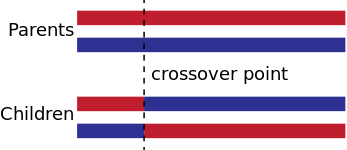

The mutation function was chosen as a randomized perturbation on all children, where all the bits have probability $1/n^2$ to be flipped (so the expected number of bits to be flipped is 1 for each child).

However this perfromed extremely poorly, for which we figured out several reasons:


1. The selection function is not diverse enough as it only picks individuals with cost less than the threshold.
2. The children of the parents can be a worse candidate for the selection fucntion as the crossover function is random.
3. The mutation function doesn't always bring strings closer to the solution string as it's fully random.



In order to resolve the first one, we will apply the so-called fitness proportionate selection [5], in the context of cost function:

1. The fitness function is evaluated for each individual, providing fitness values = 1-cost, which are then normalized. Normalization means dividing the fitness value of each individual by the sum of all fitness values, so that the sum of all resulting fitness values equals 1.
2. Accumulated normalized fitness values are computed: the accumulated fitness value of an individual is the sum of its own fitness value plus the fitness values of all the previous individuals; the accumulated fitness of the last individual should be 1, otherwise something went wrong in the normalization step.
3. A random number R between 0 and 1 is chosen.
4. The selected individual is the first one whose accumulated normalized value is greater than or equal to R.



The convergence rate will be lowered after this updated selection operator, but that doesn’t mean the approach is worse. The reason is that the previous method is too greedy, which will result in the lack of diversity in the population, while this approach ensures the population constantly changes so it has a higher chance to get to the actual global minimum.


The later two issues are hard to solve. Genetic algorithms generally require the offspring to be better candidates than their parents, but under the context of this problem it’s not always the case. The nature of the problem is that there are tons of local minima, while the combinations of two “good” parents won’t always give birth to “good” children. For example, for a 2*2 boards suppose 1100 and 0011 both leave one light on, any crossover would produce 2 or 3 lights on. Therefore, the problem is in fact not much different from a random search.

In [ ]:
# TEST
!python genetic_algorithm.py

1.0 done
1.1 done
1.2 done
1.0 done
1.1 done
1.2 done
1.0 done
1.1 done
1.2 done
1.0 done
1.1 done
1.2 done
1.0 done
1.1 done
1.2 done


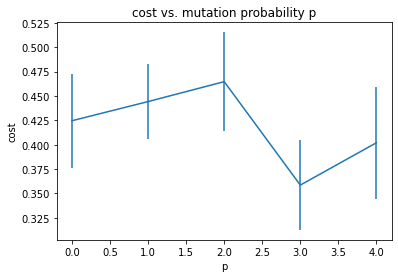

In [ ]:
plot([*range(5)], [0.4246096666666667, 0.44427600000000006, 0.46471, 0.3585043333333333, 0.4019783333333334], xlabel='p', ylabel='cost', title='cost vs. mutation probability p', error=[0.04816442799641893, 0.03814500981779925, 0.050730950993123185, 0.04600913889169799, 0.057612573218776546])

#### **Simulated Annealing**

It was very straightforward implementing the simulated annealing algorithm in Python. The temperature was decreased using the following schedule:

$$
T_i = c \cdot T_{i-1} \longrightarrow T_i = \{c^i \cdot T_0: c \in \{0, 1\}, T_0 > 0 \}
$$

Where $T_0$ is the initial temperature, defined by a hyperperameter, $T_i$ is the temperature at iteration $i$, and $c$ is the cooling factor.

The hardest part was coming up with good mutation functions. A good mutation function for simulated annealing needs to be able to be able to mutate the initial state to any state which may be the global optimum in a small number of mutations, limiting the diameter of the search graph. On the other hand, the neighbors of a state should be sufficiently near that state such that the algorithm could progressively and iteratively improve its parameters. Several mutation algorithms were considered:

1. Mutating random parameter values given some probability $p$. This is very efficient if the probability $p$ is very small, since it runs in $O(N \min(p, 1-p))$ time, where $N$ is the total number of parameters ($n^2$ for an $n \times n$ board). See equation (1).

2. Mutating random parameter values for ‘reasonable’ parameters given some probability $p$. Parameters that can turn at least one light off are considered ‘reasonable’, while any other parameter is not (since it will cause a worse position).


3. Mutating random parameters relating to a block on the board of a given size $s$. This takes advantage of the problem’s locality, by only mutating a portion of the board at a time.


After each mutation, an acceptance probability is calulated based on how much worse the cost of the current parameters is than the cost of the previous parameters:

$$
\begin{equation}
  P(c, c', T) =
  \begin{cases}
    1 & \text{if } c' \le c \\
    e^{-\frac{c' - c}{T} } & \text{if } c' > c
  \end{cases}
\end{equation}
$$

Where $c'$ is the cost of the mutated parameters, $c$ is the cost of the current parameters. When $T \ll 1$, $\frac{c' - c}{T} \gg 1$, and $e^{-\frac{c' - c}{T} } \ll 1$, making it much less likely to accept worse mutations.

Furthermore, additional parameters were added to the simulated annealing algorithm to improve convergence:

- Restarting the current parameters to the best found parameters if the current cost is too high when compared to the best cost. The likelihood of this occurring depends on how high the current cost is when compared to the best cost.


- Changing the mutation probability as a function of the current temperature, such that larger changes occur when the temperature is high, and smaller changes occur once the temperature is low.

#### **Linear Algebra**

At first I was trying to use decent method like gradient decent, there are some problems that I encountered. Intuitively, the function f(x) that we are trying to minimize represent the number of lights left on the board, and x is the configuration vector of the board. But I quickly found out that this function has so many local minimums and the minimums are not related to each other. The lights we need to toggled to get to f=0 can be completely different than the lights we need to toggle to get to f=1. This was not a good sign for using most optimization methods that I knew, so I turned to implement finding the exact solution using linear algebra, as a baseline for simulating annealing and generic algorithm. By comparing the result and running time, we can evaluate how effective those algorithms are.

To solve $A\vec{x}=\vec{b}$, I use Gaussian Elimination method. Since $A$ is  irrelevant to the board configuration $\vec{x}$ or $\vec{b}$, we can first find $A^{-1}$ and for any problem $\vec{b_{i}}$, just applied matrix multiplication $A^{-1}\vec{b_{i}}$ and it gives the solution $\vec{x_{i}}$. Therefore the time $T(n)$ to solve n configurations ($b_1, b_2, ...b_n$): 

$$
T(n)=T_0+n\times T_1
$$

where $T_0$ is time to find $A^{-1}$ and $T_1$ is the time to do matrix multiplication.

Gaussian Elimination is a sequence of row operations that change matrix A to row echelon form. When the determinant of the matrix is not 0($det(A)\ne0$), $A$ is able to change to the identity matrix $I$. Row operations includes row exchange($r_i\rightarrow r_j, r_j\rightarrow r_i$) and row addition ($r_i\rightarrow ar_i+br_j$). In this particular problem, since a row in $A$ is a sequence of bits, row addition is just the element-wise XOR operation. 

To find $A^{-1}$, just apply the exact sequence of row operations that change $A$ to identity matrix on the identity matrix. If $GE$ denotes the Gaussian Elimination $GE(A)=I$, then $GE(I)=A^{-1}$. 

However, there is a complication: if $det(A)=0$. At first I don't know what to do but to print "no exact solution". Then I realized that there are null space in this situation. For a configuration vector $\vec{b}$, there are either 0 or multiple exact solutions. We can still do Gaussian Elimination but $GE(A)=I^*\ne I$,  $GE(I)=(A^{-1})^*$, and $\vec{x}^*=(A^{-1})^*\vec{b}$. For configuration with no exact solutions, the solution $\vec{x}^*$ yields good enough scores; for configuration with multiple solutions, any of the solution can turn the lights out completely($A\vec{x}^*= \vec{b}$).

# **Results**

The Linear Algebra approach could be used to find the exact solution for small board sizes (up to $200 \times 200$), but became prohibitively expensive for larger board sizes since its complexity increased as a function of $n^4$ where the board has dimensions $n \times n$.

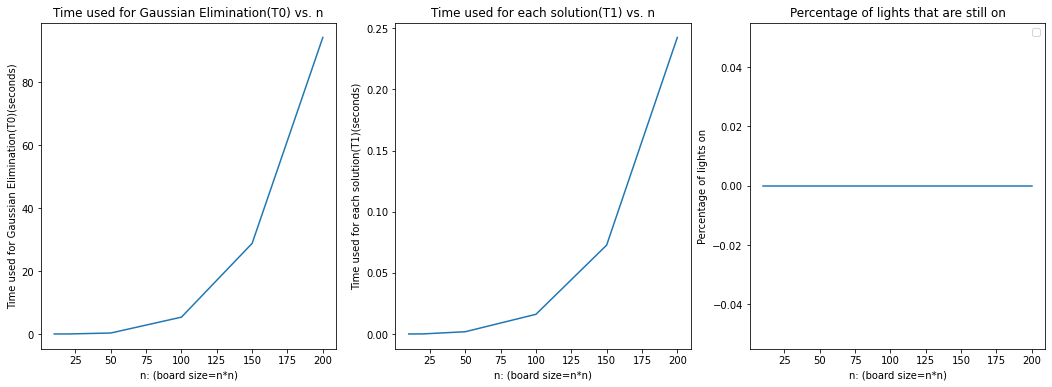

While the two optimization methods tested (a genetic algorithm and simulated annealing) were able to improve initial board configurations, they generally were not able to reach the global optimum.

These optimization methods were tested on a $1000 \times 1000$ board, as this board size is well outside the bounds of what is feasible to solve with the linear algebra approach.

The simulated annealing method was tested as follows:

*   Create a random lights out board configuration.

*   Set the initial temperature, the cooling factor, maximum and minimum mutation probability, and the maximum amount of increasing suboptimal mutations before it considers restarting at the previously found best parameter values.

*   Run simulated annealing iterations until it finds a local optimum. The criterion used to detect local optima is 1000 iterations without an accepted mutation.

*   Take note of the number of iterations taken, along with the number of lights that were successfully turned off.




The simulated annealing algorithm had a big dependence on the mutation probabilty parameter, as shown below:

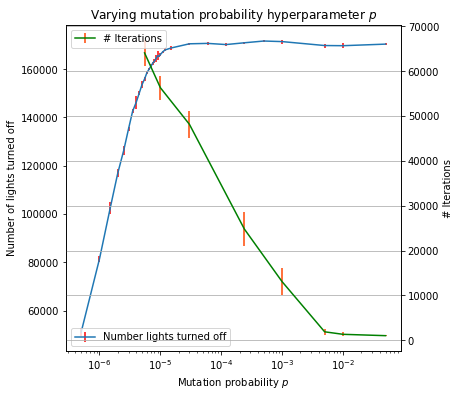

In [ ]:
plot(xlabel = 'Mutation probability $p$', ylabel = 'Number of lights turned off', title = 'Varying mutation probability hyperparameter $p$', label = 'Number lights turned off', secondylabel = '# Iterations', secondlabel = '# Iterations', xscale = 'log', xlist = [5.00E-07, 1.00E-06, 1.50E-06, 2.00E-06, 2.50E-06, 3.00E-06, 3.50E-06, 4.00E-06, 4.50E-06, 5.00E-06, 5.50E-06, 6.00E-06, 6.50E-06, 7.00E-06, 7.50E-06, 8.00E-06, 8.50E-06, 9.00E-06, 9.50E-06, 1.00E-05, 1.10E-05, 1.20E-05, 1.50E-05, 3.00E-05, 6.00E-05, 0.00012, 0.00024, 0.0005, 0.001, 0.005, 0.01, 0.05], ylist = [51063.8, 81408.6, 102469, 117005, 126334.2, 135290.2, 142561, 146214, 150117.6, 153645, 155940.6, 158480.8, 159950.6667, 161199, 162524.8, 163395, 164458, 165594.6667, 165293.6667, 166073.2, 167252.875, 168001.4, 168788.2, 170525.2, 170692, 170210.6, 170944.4, 171674.6, 171438.2, 169805.8, 169736.8, 170390.4], error = [1682.485278, 1164.029569, 2580.272794, 1464.935423, 1770.57703, 738.582097, 868.6750904, 2497.716158, 884.8067507, 1532.415004, 746.1690926, 632.9481338, 455.9123328, 810.8369324, 645.9655473, 986.8269725, 1623.88044, 1981.602223, 306.1872492, 523.3010397, 428.6144174, 591.3808308, 740.7661137, 492.8926587, 747.0436478, 675.6066322, 444.9351682, 435.8485548, 799.0852812, 821.1251179, 985.2012032, 425.6522405], secondxlist = [5.50E-06, 1.00E-05, 3.00E-05, 0.00024, 0.001, 0.005, 0.01, 0.05], secondylist = [64079.6, 56326.6, 48160.4, 24797.8, 13071.4, 1894, 1335.8, 1033.6], seconderror = [2953.433559, 2705.912859, 2941.686316, 3787.232068, 3061.05882, 678.881991, 415.3374426, 49.47684383])

Permutation probability's results were averaged over 5 trials, with error bars indicating a 95% confidence interval. This figure shows a clear ceiling of how good of a local minimum the simulated annealing function finds, and shows that higher mutation probabilities can reach that minimum faster, confirming the idea that the mutation function should be able to quickly traverse the state space.

The genetic method was tested as follows:
*   Create a random lights out board configuration.
*   Set the population size and create a random initial population.
*   Set the mutation probability for offspring.
*   Run the genetic algorithm until it reaches the maximum number of iterations or a minimum is found.

As we can show below, the final cost has a very low correlation with the population size and mutation probability.


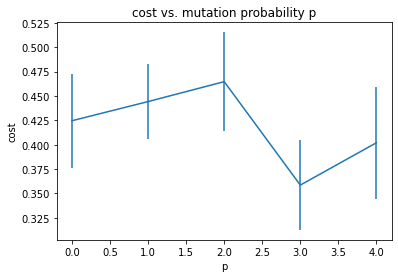

Input different mutation probabilities and plot the resulting cost:

# **Conclusion**

# **Bibliography**

[1] Anderson, M., &amp; Feil, T. (1998). Turning Lights Out with Linear Algebra. *Mathematics Magazine, 71*(4), 300. https://doi.org/10.2307/2690705 
[2] Duncan, R., Kissinger, A., Perdrix, S., &amp; Wetering, J. V. D. (2020). Graph-theoretic Simplification of Quantum Circuits with the ZX-calculus. *Quantum, 4*, 279. https://doi.org/10.22331/q-2020-06-04-279   
[3] *Fix Performance Bottlenecks with Intel® VTune™ Profiler*. Intel. https://software.intel.com/content/www/us/en/develop/tools/oneapi/components/vtune-profiler.html.   
[4] Abrahams, D., &amp; Seefeld, S. *Boost.Python*. Boost C++ Libraries. https://www.boost.org/doc/libs/1_75_0/libs/python/doc/html/index.html.  
[5] Thierens D., &amp; Goldberg D. (1994). Convergence models of genetic algorithm selection schemes. *Parallel Problem Solving from Nature — PPSN III. PPSN 1994.* https://doi.org/10.1007/3-540-58484-6_256.